# Showing daily COVID-19 cases in NSW
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxim75/data-visualization/blob/master/notebooks/COVID_data_1.ipynb)

In [17]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Load case data

In [18]:
start_date = "2021-06-25"
end_date = "2021-09-30"

# Data source 
# https://data.nsw.gov.au/nsw-covid-19-data/cases
confirmed_cases_url = "https://data.nsw.gov.au/data/dataset/aefcde60-3b0c-4bc0-9af1-6fe652944ec2/resource/21304414-1ff1-4243-a5d2-f52778048b29/download/confirmed_cases_table1_location.csv"

# load data from CSV file
cases_df = pd.read_csv(confirmed_cases_url)
cases_df.notification_date = pd.to_datetime(cases_df.notification_date)

# remove last date from data since it is incomplete
cases_df = cases_df[cases_df.notification_date < cases_df.notification_date.max()]

# filter by start_date and end_date
cases_df = cases_df[(cases_df.notification_date >= start_date) & (cases_df.notification_date <= end_date)]

# Get cases per day and 7 day mean

In [19]:
# group by notification_date and get number of records for each date
cases_per_day = cases_df.groupby(by=["notification_date"]).size().to_frame("count").reset_index()

# get 7 day average value
cases_per_day["7days_mean"] = cases_per_day.iloc[:,1].rolling(window=7, min_periods=7).mean()

# Group by LGA and date

In [20]:
cases_per_day_per_lga = cases_df\
    .groupby(by=["lga_name19", "notification_date"])\
    .size().to_frame("count").reset_index()

# Find LGAs with most number of cases

In [21]:
top_lga_count = 5
lga_total_cases_df = cases_df.groupby(by=["lga_name19"]).size().to_frame("count")\
                 .reset_index().sort_values("count", ascending=False)#.head(top_lga_count)
lga_total_cases_df.head(10)

,lga_name19,count
11,Canterbury-Bankstown (A),1567
17,Fairfield (C),1271
15,Cumberland (A),949
4,Blacktown (C),647
31,Liverpool (C),595
38,Penrith (C),360
9,Campbelltown (C) (NSW),284
37,Parramatta (C),264
18,Georges River (A),205
3,Bayside (A),183


# Plot barchart showing LGAs with most COVID-19 cases

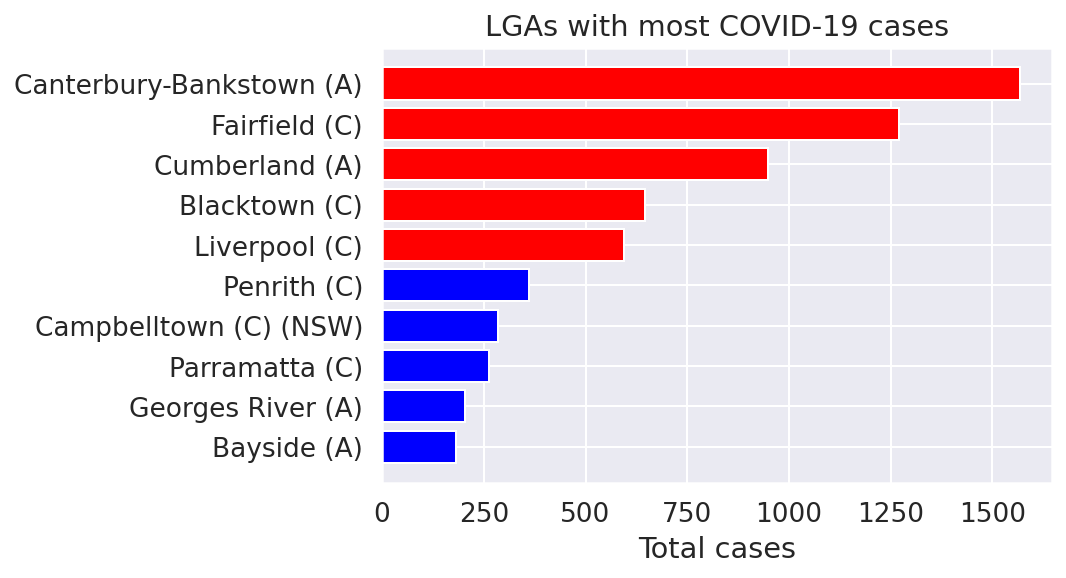

In [22]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(nrows = 1, ncols = 1)

ax.set_title("LGAs with most COVID-19 cases")
ax.set_xlabel("Total cases")

hightlight_top_count = 5

rects = ax.barh("lga_name19", "count",
    height=0.8,
    data=lga_total_cases_df.head(10),
    color=["red"]*hightlight_top_count + ["blue"]*100,
    tick_label="lga_name19"
)

plt.gca().invert_yaxis()

# Plot daily cases charts

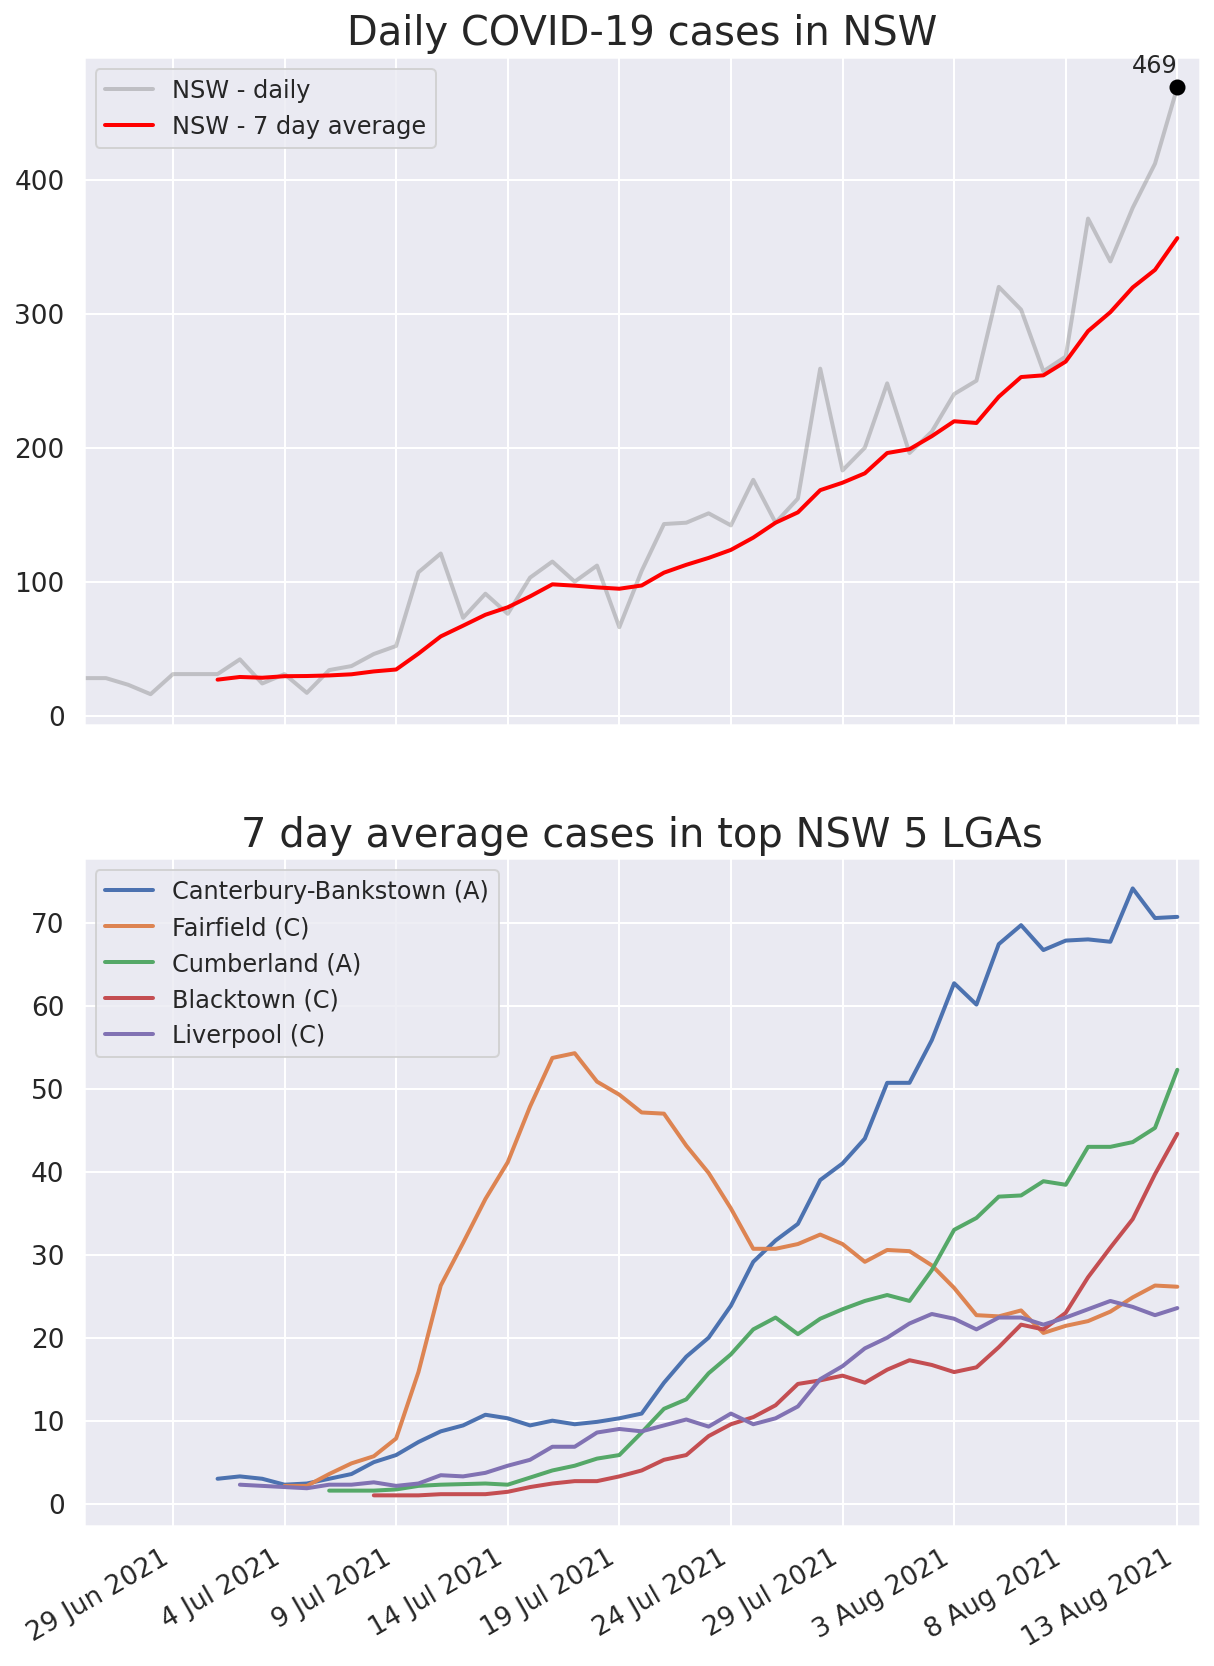

In [28]:
%config InlineBackend.figure_format = 'retina'

hightlight_date = cases_per_day.iloc[-1]

def config_datetime_axis(ax):
    date_form = mdates.DateFormatter("%-d %b %Y")
    fmt_half_year = mdates.DayLocator(interval=5)
    ax.xaxis.set_major_locator(fmt_half_year)
    ax.xaxis.set_major_formatter(date_form)
    fig.autofmt_xdate()

sns.set_theme("notebook", font_scale=1.2, rc={"lines.linewidth": 2.})

color_palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(10, 15), nrows = 2, ncols = 1)

x_lim = [cases_per_day.notification_date.min(), cases_per_day.notification_date.max() + pd.DateOffset(1)]

# Plot total cases and 7 day mean graph
ax_total = ax[0]

ax_total.plot("notification_date", "count", data=cases_per_day, label="NSW - daily", color="grey", alpha=.4)
ax_total.plot("notification_date", "7days_mean", data=cases_per_day, color="red", label="NSW - 7 day average")

ax_total.scatter("notification_date", "count", data=hightlight_date, color="black", s=7**2, zorder=10, label=None)
ax_total.annotate(hightlight_date["count"], 
            xy=(hightlight_date["notification_date"], hightlight_date["count"]), 
            xytext=(0, 10), textcoords="offset pixels",
            horizontalalignment="right",
            verticalalignment="bottom",
           fontsize=12)

ax_total.legend(loc='upper left', bbox_to_anchor=(0, 1),fontsize=12)
ax_total.set_title("Daily COVID-19 cases in NSW", fontsize=20)
ax_total.set_xlim(x_lim)
config_datetime_axis(ax_total)

# Plot 7 day mean LGAs
ax_lga = ax[1]

top_lga_names = lga_total_cases_df.head(top_lga_count).lga_name19.to_list()

for idx, lga_name in enumerate(top_lga_names):
    lga_cases = cases_per_day_per_lga[cases_per_day_per_lga.lga_name19 == lga_name].copy()
    lga_cases["mean"] = cases_per_day_per_lga[cases_per_day_per_lga.lga_name19 == lga_name].copy().rolling(window=7, min_periods=7).mean()
    
    ax_lga.plot("notification_date", "mean", data=lga_cases,\
            color=color_palette[idx], label=lga_name)

ax_lga.set_xlim(x_lim)
    
ax_lga.legend(loc='upper left', bbox_to_anchor=(0, 1),fontsize=12)

text = ax_lga.set_title(f"7 day average cases in top NSW {len(top_lga_names)} LGAs", fontsize=20)

# set x-axis date values output and positioning
config_datetime_axis(ax_lga)
plt.xticks(rotation=30)

pass

## 